# CONSTANTS

In [49]:
EPOCHS = 171
LEARNING_RATE = 0.01
MANUAL_SEED = 12345
HIDDEN_NODE_COUNT = 64
DATASPLIT = 150


In [50]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# DATASET IMPORT

In [51]:
from visualize import GraphVisualization
from networkx.algorithms import community
import networkx as nx
import plotly
import os
import torch

import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

%run visualize.py


dataset = TUDataset(root='dataset/Mutag', name='MUTAG')


<Figure size 640x480 with 0 Axes>

In [52]:
data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels,
}

print(data_details)



{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


# VISUALIZATION

In [53]:
def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g,
        pos,
        node_text_position="top left",
        node_size=20,
    )
    fig = vis.create_figure()
    return fig


fig = create_graph(dataset[0])
fig.show()


In [54]:
# Defining the loaders
dataset = dataset.shuffle()


# Allocate N to train
train_dataset = dataset[:DATASPLIT]
# Allocate the remainder to test
test_dataset = dataset[DATASPLIT:]

print(len(train_dataset))
print(len(test_dataset))

train_loader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)


150
38


# MODEL

In [55]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, in_features=7, hidden_channels=64, outfeatures = 2):
        super(GCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(in_features, hidden_channels)

        # Hidden layers
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.lin = Linear(hidden_channels, outfeatures)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


# Set a manual seed andiinstantiate the model
torch.manual_seed(MANUAL_SEED)
model = GCN(hidden_channels=64)

# PLOTTING FUNCTIONS

In [56]:
import sklearn
from sklearn.metrics import RocCurveDisplay
import numpy as np


# ROC AUC PLOT
def plotROCAUC(labels, scores):
    # roc_auc = roc_auc_score(labels, scores)
    RocCurveDisplay.from_predictions(labels, scores)
    plt.show()

# ACCURACY PLOT
def plotAccuracy(losses, accuracies, title):
    plt.title(title)

    plt.ylim(0, 1)
    plt.plot(losses)
    plt.plot(accuracies)
    plt.plot(losses, label="Loss")
    plt.plot(accuracies, label="Accuracy")
    plt.legend(loc="lower center")
    plt.show()


# TRAINING AND TEST FUNCTIONS

In [57]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = torch.nn.CrossEntropyLoss()

train_losses, train_accuracies = [], []
train_labels, train_scores = [], []

def train(t):
    model.train()

    for data in train_loader:  # Iterates the batches. We declared each batch to be of size 64

        # Calculate output, and get the maximum of those in order to obtain the predicted value
        out = model(data.x, data.edge_index, data.batch)
        cat = torch.argmax(out, dim=1)

        accuracy = (cat == data.y).float().mean()
        train_accuracies.append(accuracy.item())
        loss = loss_function(out, data.y)
        t.set_description("loss: %2f. accuracy %2f." % (loss, accuracy))
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append actual and preddicted to respective array. Have to be converted to NumPy arrays in order to flatten them.
        # We flatten them as 1D arrays are required by SK in order to calculate and plot ROC AUC
        arrayLabel = np.array(data.y)
        for value in arrayLabel.flatten():
            train_labels.append(value)

        arrayCat = np.array(cat)
        for value in arrayCat.flatten():
            train_scores.append(value)
    

test_losses, test_accuracies = [], []
test_labels, test_scores = [], []

def test(loader):
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        cat = torch.argmax(out, dim=1)

        accuracy = (cat == data.y).float().mean()
        test_accuracies.append(accuracy.item())

        loss = loss_function(out, data.y)
        test_losses.append(loss.item())

        arrayLabel = np.array(data.y)
        for value in arrayLabel.flatten():
            test_labels.append(value)

        arrayCat = np.array(cat)
        for value in arrayCat.flatten():
            test_scores.append(value)



# EXECUTION

loss: 0.294205. accuracy 0.883333.: 100%|██████████| 170/170 [00:12<00:00, 14.02it/s]


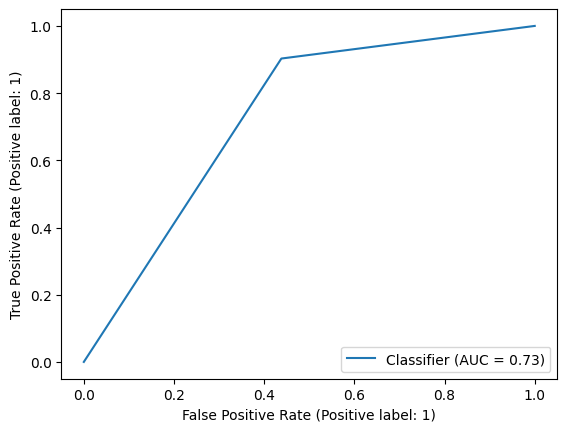

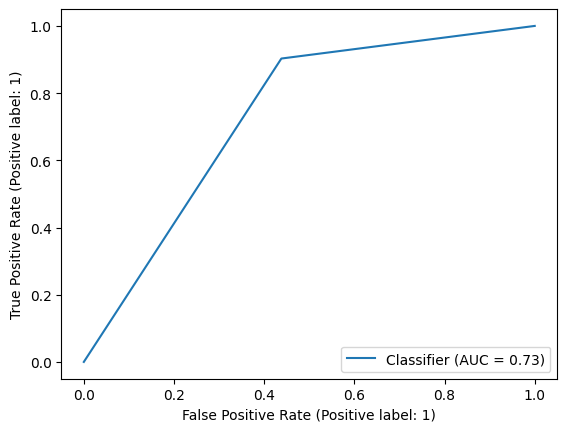

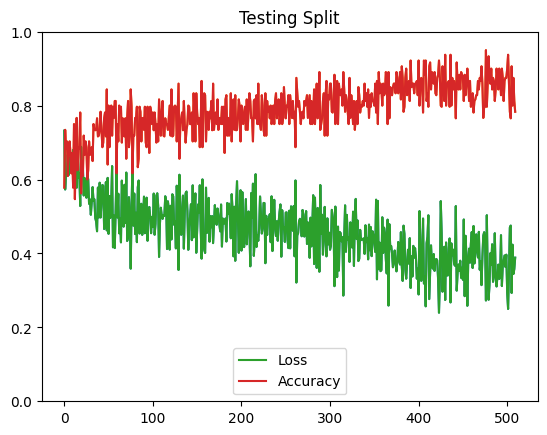

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

for epoch in (t := trange(1, EPOCHS)):
    train(t)
    test(train_loader)

# Flags
plot_training = True
plot_testing = True

plot_accuracy = False
plot_rocauc = True



# Plot for train
if(plot_training):
    if(plot_accuracy):
        plotAccuracy(train_losses, train_accuracies, "Training Split")

    if(plot_rocauc):
        plotROCAUC(train_labels, train_scores)

if(plot_testing):
    if(plot_accuracy):
        plotAccuracy(train_losses, train_accuracies, "Training Split")

    if(plot_rocauc):
        plotROCAUC(test_labels, test_scores)
# Plot for test
